In [1]:
# IGNORE THIS CELL WHICH CUSTOMIZES LAYOUT AND STYLING OF THE NOTEBOOK !
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings = lambda *a, **kw: None
from IPython.core.display import HTML; HTML(open("custom.html", "r").read())

# Chapter 5: An overview of classifiers

This script gives a quick hands-on overview of **how different types of classifiers work, their advantages and their disadvantages**. This should give you an idea of a concept behind each classifier type as well as when and which classifier type to use.

<img src="https://i.imgflip.com/303zjr.jpg" title="made at imgflip.com" width=50%/>

For the sake of visualisation we continue with 2 dimensional data examples. For different classifiers we'll be looking at their decision surfaces. Let's start with some helper functions for that:

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def samples_color(ilabels, colors=["steelblue", "chocolate"]):
    '''Return colors list from labels list given as indices.'''
    return [colors[int(i)] for i in ilabels]

def plot_decision_surface(
    features_2d, labels, classifier, preprocessing=None,
    plt=plt, marker='.', N=100, alpha=0.2, colors=["steelblue", "chocolate"], title=None,
    test_features_2d=None, test_labels=None, test_s=60,
):
    '''Plot a 2D decision surface for a already trained classifier.'''

    # sanity check
    assert len(features_2d.columns) == 2

    # pandas to numpy array; get min/max values
    xy = np.array(features_2d)
    min_x, min_y = xy.min(axis=0)
    max_x, max_y = xy.max(axis=0)

    # create mesh of NxN points; tech: `N*1j` is spec for including max value
    XX, YY = np.mgrid[min_x:max_x:N*1j, min_y:max_y:N*1j]
    points = np.c_[XX.ravel(), YY.ravel()] # shape: (N*N)x2

    # apply scikit-learn API preprocessing
    if preprocessing is not None:
        points = preprocessing.transform(points)
    
    # classify grid points
    classes = classifier.predict(points)

    # plot classes color mesh
    ZZ = classes.reshape(XX.shape) # shape: NxN
    plt.pcolormesh(
        XX, YY, ZZ,
        alpha=alpha, cmap=matplotlib.colors.ListedColormap(colors),
    )
    # plot points
    plt.scatter(
        xy[:,0], xy[:,1],
        marker=marker, color=samples_color(labels, colors=colors),
    );
    # set title
    if title:
        if hasattr(plt, 'set_title'):
            plt.set_title(title)
        else:
            plt.title(title)
    # plot test points
    if test_features_2d is not None:
        assert test_labels is not None
        assert len(test_features_2d.columns) == 2
        test_xy = np.array(test_features_2d)
        plt.scatter(
            test_xy[:,0], test_xy[:,1],
            s=test_s, facecolors='none', color=samples_color(test_labels),
        );


## Nearest Neighbors

The idea is very simple: to classify a sample $x$ look for **$N$ closests samples in the training data** (by default, using the Euclidean distance) and take **majority of their labels** as a result.

This method does well where the fast linear classifiers would fail, such as with the XOR dataset:

In [3]:
import pandas as pd

df = pd.read_csv("xor.csv")
df.head(2)

,x,y,label
0,-1.539782,0.950822,False
1,0.436266,-1.768324,False


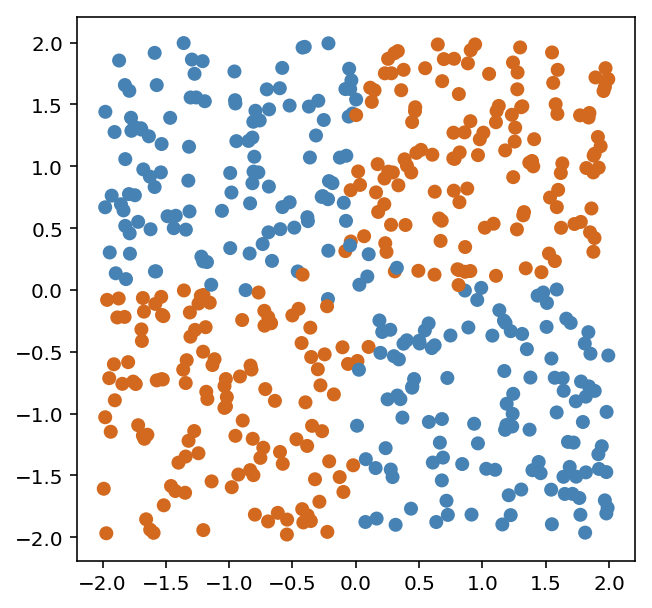

In [4]:
features_2d = df.loc[:, ("x", "y")]
labelv = df["label"]

plt.figure(figsize=(5, 5))
plt.scatter(features_2d.iloc[:,0], features_2d.iloc[:,1], color=samples_color(labelv));

You will find the Nearest Neighbors method in the `sklearn.neighbors` module.

train score: 97.33%
test score: 93.60%


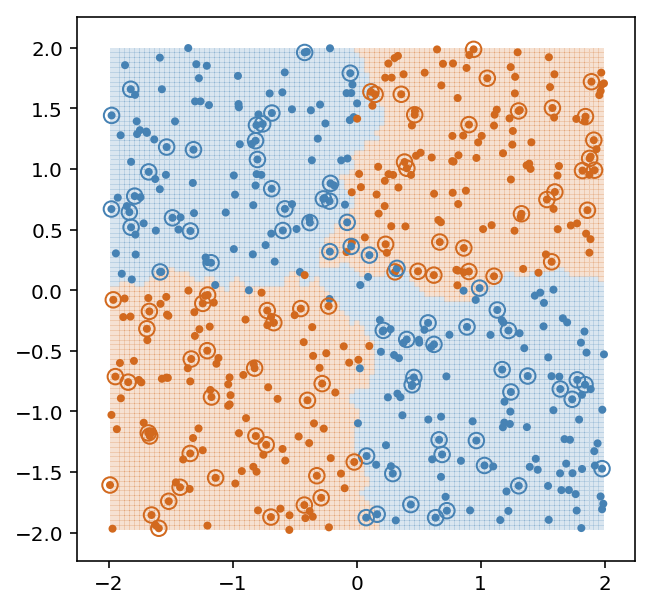

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_2d, labelv, random_state=10)

# Let's use 5 neighbors to learn
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)

print('train score: {:.2f}%'.format(100*classifier.score(X_train, y_train)))
print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))

plt.figure(figsize=(5, 5))
plot_decision_surface(
    features_2d, labelv, classifier,
    test_features_2d=X_test, test_labels=y_test,
)

About the plot: **the points surrounded by a circle are from the test data set** (not used for learning), all other points belong to the training data.

We can query directly for the closest neighbors of a point. Let's check neighborhood of the origin:

In [6]:
# distances and row indices of neighbours around (0, 0):
dist_nn, ind_nn = classifier.kneighbors([[0, 0]])

# tech: simplify dimensions
ind_nn = ind_nn.squeeze()
dist_nn = dist_nn.squeeze()

# build data frame with neighbours
df = X_train.iloc[ind_nn, :].copy()
df["label"] = y_train.iloc[ind_nn]
df["dist"] = dist_nn
df 

,x,y,label,dist
496,0.028310,0.042214,False,0.050828
137,0.091190,0.109028,False,0.142137
51,-0.219754,-0.073249,False,0.231641
194,0.186789,-0.246576,False,0.309338
216,-0.082451,0.314070,True,0.324712


### Exercise section

Experiment with the few classifier parameters. Start with number of neighbors (`n_neighbors`) but also try the Manhatan distance norm `p = 1` (`2` is Euclidian distance).

#### Optional exercise


Instead of choosing a number of neighbors you can also specify a radius within which samples make decision, or center of a closest class. Compare decision surface for these methods, as represented by [`RadiusNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.RadiusNeighborsClassifier.html#sklearn.neighbors.RadiusNeighborsClassifier) and [`NearestCentroid`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestCentroid.html#sklearn.neighbors.NearestCentroid) classifiers in the scikit-learn library.

<div class="alert alert-block alert-info">
<i class="fa fa-info-circle"></i>
    Choice of an specific querying algorithm (<code>algorithm</code> parameter) becomes important with larger datasets. It depends on many factors; see: <a href="https://scikit-learn.org/stable/modules/neighbors.html#choice-of-nearest-neighbors-algorithm"><em>Choice of Nearest Neighbors Algorithm</em>.</a>.
</div>



## Few words about the role of optimization in ML

Many machine learning algorithms adapt internal weights (or similar parameters) such that the predicted labels match the given labels as good as possible.

Mathematically this is formulated as an optimzation problem which **minimizes a cost function**. Solution is usually computed in iterative improvements.

<table>
    <tr><td><img src="cost_minimization_iterative.png" width=400px></td></tr>
    <tr><td><center><sub>Source: <a href="https://towardsdatascience.com/machine-learning-fundamentals-via-linear-regression-41a5d11f5220">https://towardsdatascience.com/machine-learning-fundamentals-via-linear-regression-41a5d11f5220</a></sub></center></td></tr>
</table>


As the optimization (cost minimization) only considers training data, minimizing the **classification error/loss** can introduce overfitting. We've seen this before in the overfitting chapter. To compensate for that we add a regularization term which penalizes more complex models.

The cost function then consists of an term measuring a classification loss and an additional **regularization penalty**:

$$\text{cost} =  \text{classification_loss} + \lambda \cdot \text{regularization_penalty}$$

The **regularization weight $\lambda$** allows to balance out both terms and must be chosen depending on the actual algorithm and the data. In general:

* $\lambda$ close to `0`, $$\text{cost} \approx \text{classification_loss},$$ implies more focus on training data, thus, more complex models and possible overfitting,
* $\lambda$ very large, $$\text{cost} \approx \lambda\cdot\text{regularization_penalty},$$  implies less focus on training data, thus, simpler models and possible underfitting.

This is a mathematical concept which relates to [Occam's razor](https://en.wikipedia.org/wiki/Occam%27s_razor) which states *"simpler solutions are more likely to be correct than complex ones."*

## Logistic Regression

The name is misleading: a) despite "logistic" the method is linear, b) despite "regression" (as in unsupervised learning), it's a classification method.

The method uses linear regression to learn weights $w_1,\cdots,w_n$ for sum of features and the threshold $b$, i.e. to learn a spearation hyper-plane; threshold is the plane's **intercept**. Then, to classify, transform the weighting result to a probability of belonging to one of the two classes using the logistic function:



$$
p\left(x_1,\cdots,x_n\right)=\frac{1}{1+\exp\left(b - \sum_{i=1}^{n} w_i x_i\right)}.
$$

which looks like that:

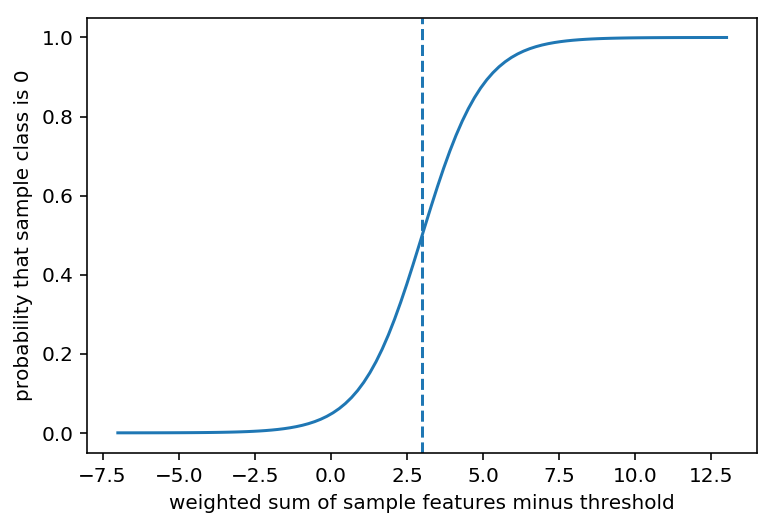

In [7]:
# classification threshold
threshold = 3
# results of weighted sum (around the threshold)
weighted_sum = np.linspace(-10 + threshold, 10 + threshold, 100)
# logistic function
plt.plot(weighted_sum, 1 / (1 + np.exp(threshold - weighted_sum)))
plt.axvline(x=threshold, linestyle='--')

plt.ylabel("probability that sample class is 0")
plt.xlabel("weighted sum of sample features minus threshold");

In [8]:
import pandas as pd

df = pd.read_csv("line_separable_2d.csv")
df.head(2)

,x,y,label
0,-3.252709,-0.821378,0
1,-3.816946,-0.906188,0


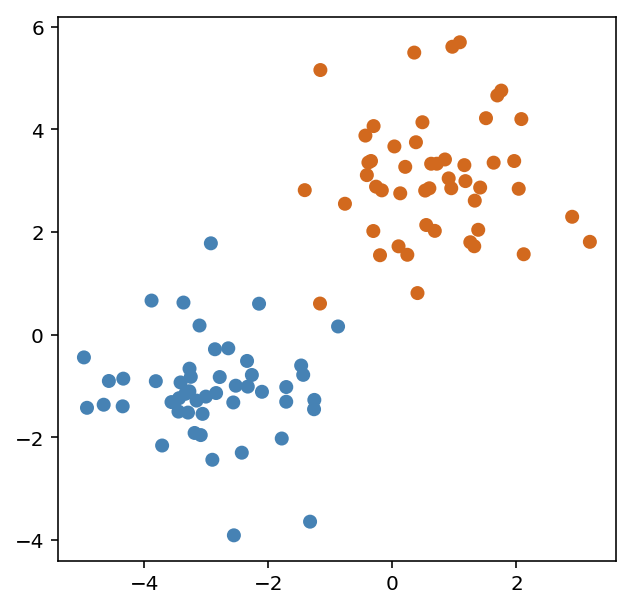

In [9]:
features_2d = df.loc[:, ("x", "y")]
labelv = df["label"]

plt.figure(figsize=(5, 5))
plt.scatter(features_2d.iloc[:,0], features_2d.iloc[:,1], color=samples_color(labelv));

Let's learn a logistic regression model. The regularization weight is passed here in "inverse", as classification weight, parameter `C` (default `1`), meaning that it multiplies the classification loss, not the regularization penalty:

$$\text{cost} =  \text{C}\cdot\text{classification_loss} + \text{regularization_penalty}$$



You can find the Logistic Regression method in the `sklearn.linear_model` module.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_2d, labelv, random_state=0)

classifier = LogisticRegression(C=1, random_state=0)
classifier.fit(X_train, y_train)
print('train score: {:.2f}%'.format(100*classifier.score(X_train, y_train)))
print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))

train score: 98.67%
test score: 100.00%


Let's see how does the separation line look like here and what happens if we put more weight on the classification loss (increase `C` parameter).

feature weights: [[1.0954062  1.57492098]]


With C=100

train score: 100.00%
test score: 96.00%
feature weights: [[2.41793662 7.8702219 ]]


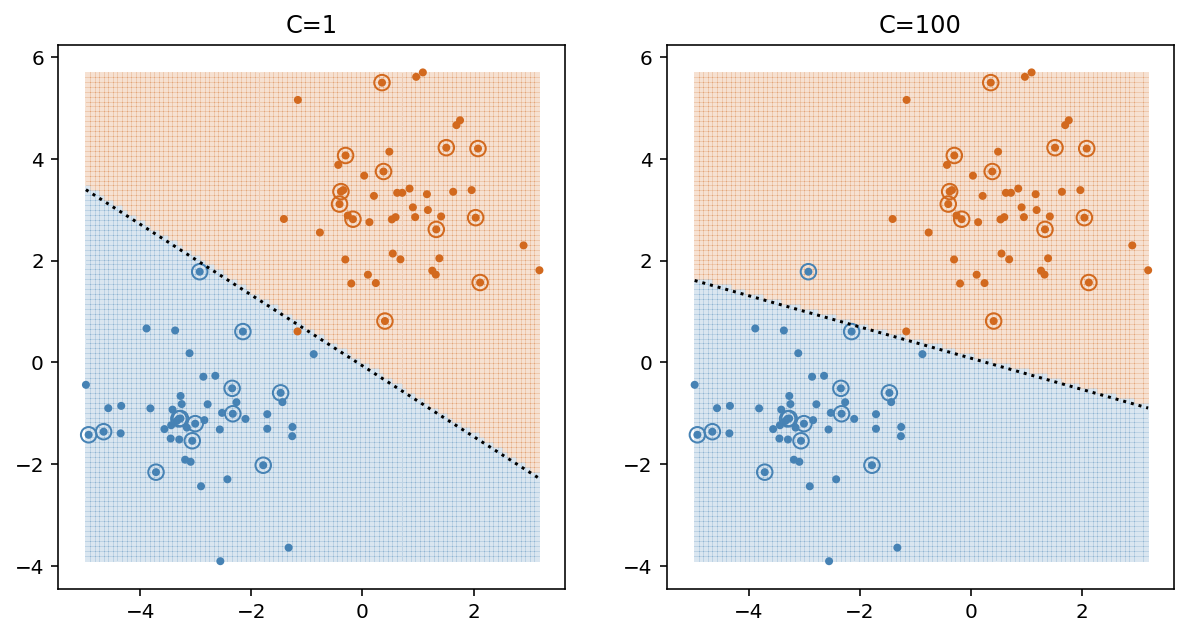

In [11]:
fig, ax_arr = plt.subplots(ncols=2, nrows=1, figsize=(2*5, 5))

plot_decision_surface(
    features_2d, labelv, classifier,
    test_features_2d=X_test, test_labels=y_test,
    plt=ax_arr[0],
    title='C=1',
)

print('feature weights:', classifier.coef_)

def plot_separation_line(features_2d, linear_classifier, plt=plt):
    '''Plot a separation line for 2D dataset'''
    
    assert hasattr(linear_classifier, 'coef_') 
    
    w = linear_classifier.coef_[0]
    b = -linear_classifier.intercept_ # NOTE: intercept = - minus threshold

    # separation line: w[0] * x + w[1] * y - b == 0
    feat_x = features_2d.iloc[:, 0]
    x = np.linspace(np.min(feat_x), np.max(feat_x), 2)
    y =  (b - w[0] * x) / w[1]
    plt.plot(x, y, color='k', linestyle=':');

plot_separation_line(features_2d, classifier, plt=ax_arr[0])


print()
print()
print('With C=100')
print()

classifier = LogisticRegression(C=100, random_state=0)
classifier.fit(X_train, y_train)
print('train score: {:.2f}%'.format(100*classifier.score(X_train, y_train)))
print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))
print('feature weights:', classifier.coef_)

plot_decision_surface(
    features_2d, labelv, classifier,
    test_features_2d=X_test, test_labels=y_test,
    plt=ax_arr[1],
    title='C=100',
)
plot_separation_line(features_2d, classifier, plt=ax_arr[1])

### Exercise section

1. Why did the test score drop when we penalized more misclassifications?
2. Experiment with higher dimensional "beers.csv" dataset and both parameters `C` and `penalty` of the linear regression classfier. Compare scores and the resulting weights. What does the `l1` penalty do? What is the sweet spot of the "inverse regularization" `C`?
  

<div class="alert alert-block alert-info">

<p><i class="fa fa-info-circle"></i>&nbsp;
The <strong>classification loss</strong> in logistic regression is a so called <em>negative-log likelihood</em>, i.e. a negative logarithm of the logistic probability above:
<p/>
    
<p>
$$ \text{classification_loss} = -\log(p(x^k; p^k)) = \log{\left(1+\exp{\left(y^k\left(b - \sum_{i=1}^{n} w_i x_i^k\right)\right)}\right)}$$
<p/>

<p>
where $y^k$ is -1 or 1, representing class of $k$-th sample from the training data, corresponding, respectively, to class below and above the threshold (the separation line).

The $+/-$ sign for the class penalizes missclassifications. If sample is below the threshold $\sum_{i=1}^{n} w_i x_i^k < b$ and have the correct class $y^k = -1$, then we have $\exp{\left(\text{negative value}\right)}$ giving small loss. In case of misclassification $\exp{\left(\text{positive value}\right)}$ gives a much bigger loss.
</p>
</div>

<div class="alert alert-block alert-info">
<p><i class="fa fa-info-circle"></i>&nbsp;
The <strong>reqularization penalty</strong> in logistic regression is a <em>norm of the learnt weights</em>, denoted as:

<p>
$$\text{regularization_penalty} = \left\lVert w \right\rVert_p$$
</p>

<p>
Using <em>L1 norm</em> ($p=1$, Manhatan distance from origin, which is sum of absolute weight values) is know for finding sparse solutions, i.e. eliminating features (weight equal to 0) when they are have low significance. With the default <em>L2 norm</em> ($p=2$, Euclidian distance from origin, which is square root of sum of squared weight values), weights of insignificant features would have small non-zero values instead.
</p>

<p>
In <code>LogisticRegression</code> class, <code>penalty</code> parameter allows to specify type of norm to use.
</p>

<p>
Note that any solution weights and its threshold can be scaled to give the same result. Thus the regularization penalty not only prevents overfitting but also ensures a unique solution.
</p>

</div>

## Linear SVM

Support-Vector Machine classifier tries to separate two classes with a line by finding data points, called the **support vectors**, lying closest to the separation plane.

Support vectors determine separation plane, hence weights for each feature $w=(w_1,\ldots,w_n)$, plus a threshold $b$ (separation plane intercept).

The weights are learned such that the **margin between support vectors of different classes is maximized**.

<table>
    <tr><td><img src="svm_margin.png" width=400px></td></tr>
    <tr><td><center><sub>Source: <a href="https://en.wikipedia.org/wiki/Support-vector_machine">https://en.wikipedia.org/wiki/Support-vector_machine</a></sub></center></td></tr>
</table>

Like in linear regression the classification is based on a weighted sum of the features $w\cdot x=\sum_{i=1}^{n}w_i x_i$ (and margin maximization corresponds to minimization of the regularization penalty). 

Analogously to the Nearest Neighbors method the data points (support vectors) decide the class of a new data sample.

Let's try it out.

In [14]:
import pandas as pd

df = pd.read_csv("line_separable_2d.csv")
df.head(2)

,x,y,label
0,-3.252709,-0.821378,0
1,-3.816946,-0.906188,0


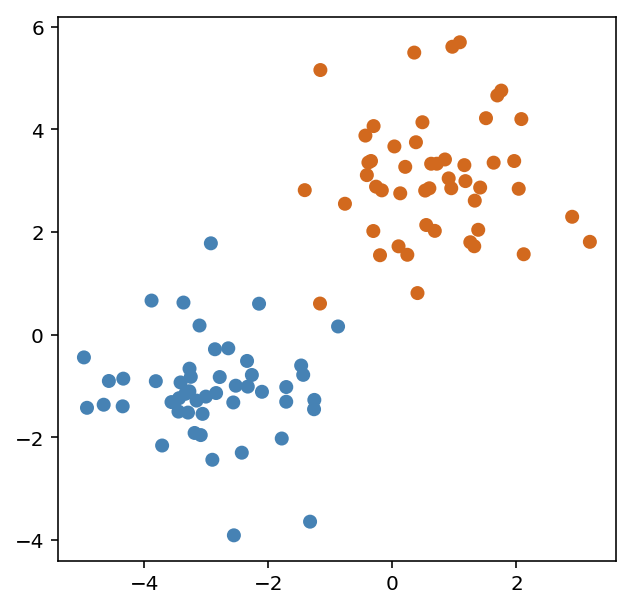

In [15]:
features_2d = df.loc[:, ("x", "y")]
labelv = df["label"]

plt.figure(figsize=(5, 5))
plt.scatter(features_2d.iloc[:, 0], features_2d.iloc[:, 1], color=samples_color(labelv));

You will find the SVM method in the `sklearn.svm` module.

In [16]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_2d, labelv, random_state=0)

classifier = LinearSVC(C=1)
classifier.fit(X_train, y_train)
print('train score: {:.2f}%'.format(100*classifier.score(X_train, y_train)))
print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))

train score: 100.00%
test score: 96.00%


Again, let's see how does the separation line look like here and what happens if we put more weight on the classification loss (increase `C` parameter).

feature weights: [[0.37981539 0.71174276]]


With C=1000

train score: 100.00%
test score: 92.00%
feature weights: [[0.94878052 5.07117193]]


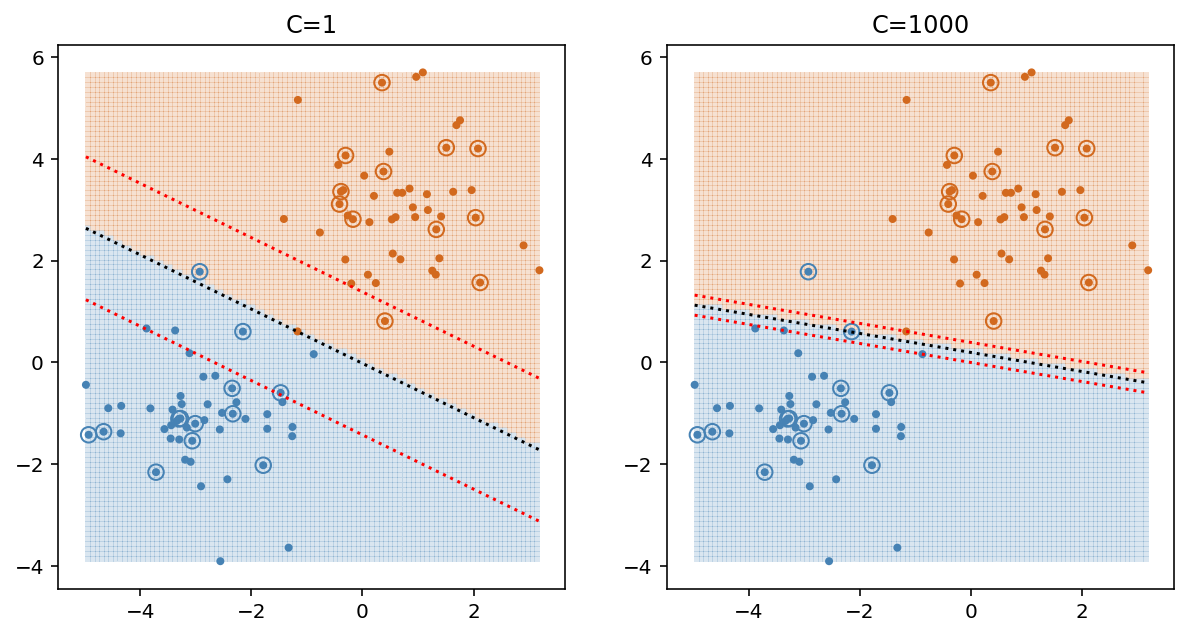

In [17]:
fig, ax_arr = plt.subplots(ncols=2, nrows=1, figsize=(2*5, 5))
                                                      
plot_decision_surface(
    features_2d, labelv, classifier,
    test_features_2d=X_test, test_labels=y_test,
    plt=ax_arr[0],
    title='C=1', 
)

print("feature weights:", classifier.coef_)

def plot_support_vectors(features_2d, linear_classifier, plt=plt):
    '''Plot a separation line and support vectors for 2D dataset'''
    
    assert hasattr(linear_classifier, 'coef_') 
    
    w = linear_classifier.coef_[0]
    b = -linear_classifier.intercept_ # NOTE: intercept = - minus threshold

    # separation line: w[0] * x + w[1] * y - b == 0
    feat_x = features_2d.iloc[:, 0]
    x = np.linspace(np.min(feat_x), np.max(feat_x), 2)
    y =  (b - w[0] * x) / w[1]
    plt.plot(x, y, color='k', linestyle=':');

    # margin lines: w[0] * x + w[1] * y - b == +/-1
    y =  ((b - 1) - w[0] * x) / w[1]
    plt.plot(x, y, color='r', linestyle=':');
    y =  ((b + 1) - w[0] * x) / w[1]
    plt.plot(x, y, color='r', linestyle=':');

plot_support_vectors(features_2d, classifier, plt=ax_arr[0])


print()
print()
print('With C=1000')
print()
                                                      
# higher C = more narrow ("harder") margin
classifier = LinearSVC(C=1000)
classifier.fit(X_train, y_train)
print('train score: {:.2f}%'.format(100*classifier.score(X_train, y_train)))
print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))
print("feature weights:", classifier.coef_)

plot_decision_surface(
    features_2d, labelv, classifier,
    test_features_2d=X_test, test_labels=y_test,
    plt=ax_arr[1],
    title='C=1000', 
)
plot_support_vectors(features_2d, classifier, plt=ax_arr[1]);

Why are there **training data samples within the margin** in the first example?

This is because the scikit-learn `LinearSVC` implementation by default uses so called **"soft margins"**, which introduces a so called **hinge** loss function (`loss` parameter of the `LinearSVC` class). It allows support vectors to lie within the -1, 1 margin (with lower weights).

You can control "softness" or "hardness" of classification loss by, respectively, decreasing or increasing its weight (parameter `C` of the `LinearSVC` class). Just like we did in the second example, where there are no training points within the margin.

## Exercise section

1. It looks like we did train our classifier "perfectly" (no point within the margin) with "harder" margins. Why is the score then lower then previously?
2. Experiment with higher dimensional "beers.csv" dataset and both parameters `C` and `penalty` of the linear SVM classfier (note: set `dual=False` to work with `penalty='l1'`). Compare scores and the resulting weights.
  

In [18]:
df = pd.read_csv("beers.csv")

C_values = [0.01, 0.1, 1, 10, 100]
penalty_values = ['l1', 'l2']

# ...

## Kernel based SVM

Data is usually not at all linearily separable.

Let's revisit the "circle" data.

In [21]:
import pandas as pd

df = pd.read_csv("circle.csv")
df.head(2)

,x,y,label
0,-0.501840,1.802857,False
1,0.927976,0.394634,True


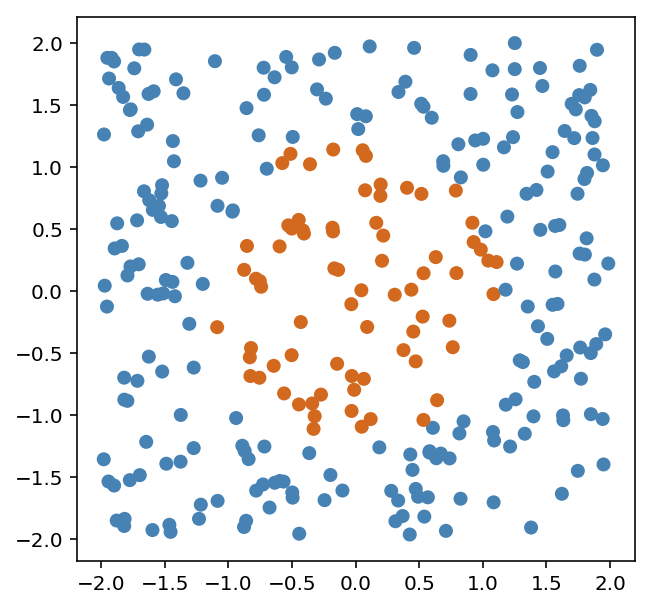

In [22]:
features_2d = df.loc[:, ("x", "y")]
labelv = df["label"]

plt.figure(figsize=(5, 5))
plt.scatter(features_2d.iloc[:,0], features_2d.iloc[:,1], color=samples_color(labelv));

As done in previous scripts, we can engineer a feature to map each data sample $(x,y)$ into a higher-dimensional features space and learn a linear classifier therein.

We write this mapping as $\phi((x,y))$.

Let's add a feature giving distance to the center $(0, 0)$, hence make $\phi((x,y))=(x, y, x^2+y^2)$ map from 2D to 3D features space:

In [23]:
from sklearn.preprocessing import FunctionTransformer

# np array in and out
def phi(arr_2d):
    xv = arr_2d[:,0]
    yv = arr_2d[:,1]
    distv = (xv ** 2 + yv ** 2)
    return np.vstack([xv, yv, distv]).T

# `validate=True` converts to np array
add_distance_to_zero = FunctionTransformer(phi, validate=True)

features_3d = pd.DataFrame(add_distance_to_zero.transform(features_2d),
                           columns=["x", "y", "x^2 + y^2"])
features_3d.head(3)

,x,y,x^2 + y^2
0,-0.501840,1.802857,3.502137
1,0.927976,0.394634,1.016875
2,-1.375925,-1.376022,3.786607


score: 97.33%
feature weights: [[-0.064403   -0.09749909 -1.956596  ]]


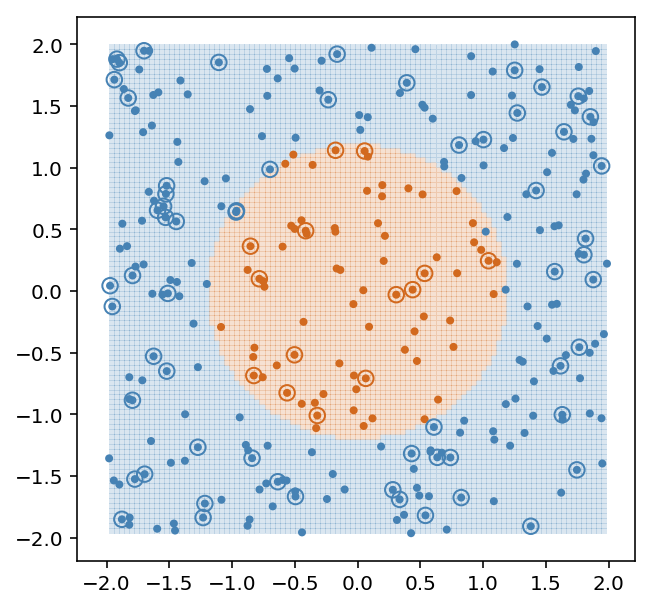

In [24]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_3d, labelv, random_state=0)

classifier = LinearSVC()
classifier.fit(X_train, y_train)
print('score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))

plt.figure(figsize=(5, 5))
plot_decision_surface(
    features_2d, labelv, classifier,
    preprocessing=add_distance_to_zero,
    test_features_2d=X_test.iloc[:,:2], test_labels=y_test,
)

print("feature weights:", classifier.coef_)

#### How can we construct such mapping $\phi$?

The kernel SVM method avoids explicit construction of $\phi$, and instead starts with a so called *similarity measure* $K$.

One examples is a Radial Basis Function (RBF)

$$
K(x, y) = e^{-\gamma ||x - y||}
$$

It is a Gaussian-shaped similarity measure that returns `1` for the same points and declines exponentially to `0` with distance increasing between points, with a *decline rate* controlled by the $\gamma$ parameter.


Using the so called **kernel trick**, SVC uses such similarity measure (kernel) as if applying mapping $\phi$, without actually applying it, followed by a linear SVM.


<table>
    <tr><td><img src="rock_driving-kernel_trick.jpg" width=400px></td></tr>
</table>


<div class="alert alert-block alert-info">
<p><i class="fa fa-info-circle"></i>&nbsp;
A mapping to higher dimensions is costly to compute and store for the whole dataset. However, linear SVM just needs to know values of sums of mulitplied feature values between data sample and support vectors, called <em>dot-product</em>. Hence, kernel SVM does the <strong>kernel trick</strong> by using a pre-selected kernel function by assuming $K(x, y) = \phi(x)\cdot\phi(y)$, i.e. such that it gives values as if the similarity was computed after the mapping, but do not explicitly map the features to higher-dimensions.
</p>
</div>


The default kernel for `SVC` is the above Radial Basis Function (RBF). The `gamma` parameter of `SVC` controls the decline rate (higher value = slower decline).

train score: 98.67%
test score: 96.00%
#support vectors: [130  51]


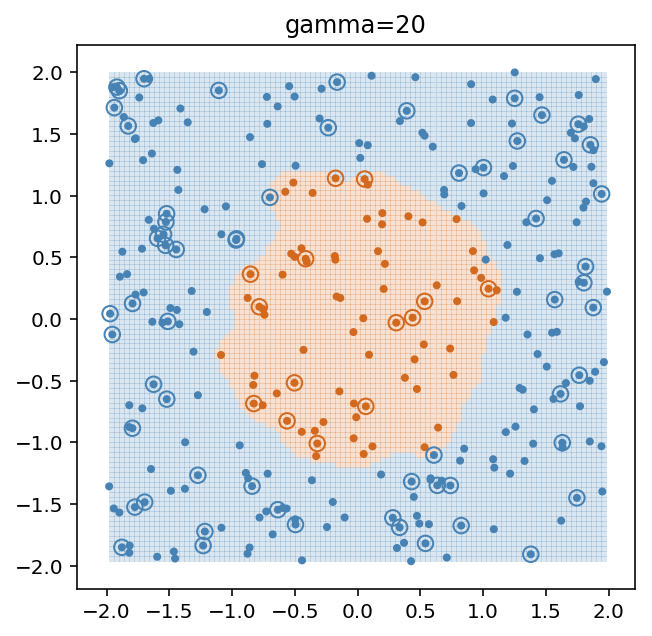

In [25]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_2d, labelv, random_state=0)

classifier = SVC(kernel='rbf', gamma=20)
classifier.fit(X_train, y_train)

print('train score: {:.2f}%'.format(100*classifier.score(X_train, y_train)))
print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))

# NOTE: mapping is implicit - feature weights are not there anymore (coef_);
#       instead we have only support vectors (and their weights; dual_coef_).
#
# Let's just see how many of samples are used as support vectors for each class.
print('#support vectors:', classifier.n_support_)

plt.figure(figsize=(5, 5))
plot_decision_surface(
    features_2d, labelv, classifier,
    test_features_2d=X_test, test_labels=y_test,
    title='gamma=20',
)

But this "circle" did not really turn out as nice as previously. The `gamma` parameter controls both size and *smoothness* of the decision surface.

**Feature scaling with `gamma` parameter is crucial for a good performance!**

<div class="alert alert-block alert-warning">
<i class="fa fa-info-warning"></i>Before using kernel SVM you need to <strong>scale (normalize) your features first</strong>. This is because it relies on the "similarity"/"distance" function. Otherwise, kernel SVM might not work well. (More about scaling of the data in the data preprocessing script.)
</div>

## Exercise section

Play with different valuse of `kernel` and `gamma` parameters of the `SVC` classifier. Which built-in kernels do work? Which gamma value to pick?

In [26]:
# Which kernels do work?
kernels = ['linear', 'poly', 'rbf', 'sigmoid',]
# gamma = ...

# ...

# Which gamma value to pick?
# kernel = ...
gammas = [0.05, 0.5, 5, 50, 'scale',]

## Few words about assigning weights to the classes

Some of the scikit-learn classifiers, such as SVM, provide a **`class_weight` parameter** which allows to assign weights to classes according to their importance. Do use it when:

* some misclassifications are more important to avoid than others, e.g. classifing an actual email as a spam is worse than the other way around, or
* your have **imbalanced data**, i.e. you have a large amount of samples for one class and much fewer observations for other classes.

<div class="alert alert-block alert-info">
<i class="fa fa-info-circle"></i>
In case of the imbalanced data, if the learning method does not support weight, you can always over/under-sample the under/over-represented classes (cf. <a href="https://imbalanced-learn.org/en/stable/introduction.html">the <code>imblearn</code> external module to be used with scikit-learn</a>).
</div>


Let's imbalance XOR dataset and pick only 5 samples from the circle interior class.

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("circle.csv")
labelv = df["label"]

# circle interior is the `True` class
idx_c1 = df.index[labelv == True][:5]
idx_c2 = df.index[labelv == False]

df = pd.concat([df.iloc[idx_c1], df.iloc[idx_c2]])
df.head(8)

,x,y,label
1,0.927976,0.394634,True
4,0.404460,0.832290,True
8,-0.783031,0.099026,True
9,-0.272220,-0.835083,True
11,-0.831421,-0.534553,True
0,-0.501840,1.802857,False
2,-1.375925,-1.376022,False
3,-1.767666,1.464705,False


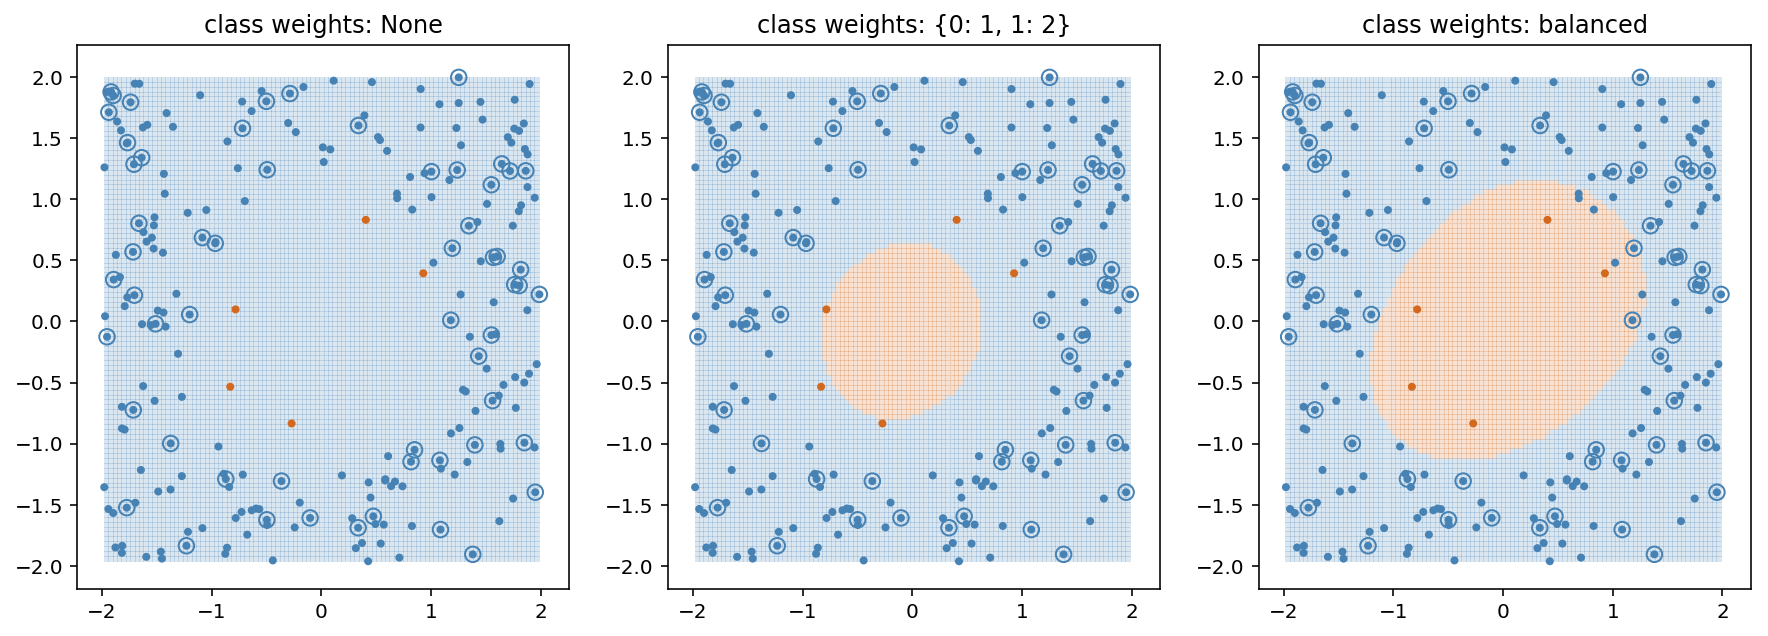

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

labelv = df["label"]
features_2d = df.loc[:, ("x", "y")]

X_train, X_test, y_train, y_test = train_test_split(features_2d, labelv, random_state=0)


class_weights = [
    None,          # default: no weights
    {0: 1, 1: 2},  # explicitly assigned weights as {class_number: class_weight} dict
    'balanced',    # according to nr of samples in each class
]


n_class_weights = len(class_weights)
fig, ax_arr = plt.subplots(ncols=n_class_weights, figsize=(5*n_class_weights, 5))

for i, class_weight in enumerate(class_weights):

    classifier = SVC(class_weight=class_weight)
    classifier.fit(X_train, y_train)

    plot_decision_surface(
        features_2d, labelv, classifier,
        test_features_2d=X_test, test_labels=y_test,
        title='class weights: {}'.format(class_weight),
        plt=ax_arr[i], 
    )

## Decision trees

Let's see what a decision tree by looking at an example tree created for an email spam classification problem. 

Dataset has 57 features extracted from a set of emails, such as percentages of specific words (e.g. `remove`) or characters (e.g. `ch$`), and average, max and total lengths of uninterrupted capital letters. Each node shows a dominant class, count of samples from the other class and total samples count.

<table>
    <tr><td><img src="decision_tree-spam.png" width=600px></td></tr>
    <tr><td><center><sub>Source: Hastie, T., Tibshirani, R. and Friedman, J. H. (2009), <em>The elements of statistical learning data mining, inference, and prediction</em>.</sub></center></td></tr>
</table>

### How are the decision tree splits selected?

Starting from the top the decision tree is build by selecting **best split of the datase using a single feature**. Best feature and its split value are ones that make the resulting **subsets more pure** in terms of variety of classes they contain (i.e. that minimize misclassification error, or Gini index/impurity, or maximize entropy/information gain).

<table>
    <tr><td><img src="decision_tree-split.png" width=600px></td></tr>
</table>

Features can repeat within a sub-tree (and there is no way to control it in scikit-learn), but usualy categorical features appear at most once on each path. They do, however, repeat across different tree branches.

Let's try out decision trees with the XOR dataset:

In [31]:
import pandas as pd

df = pd.read_csv("xor.csv")
df.head(2)

,x,y,label
0,-1.539782,0.950822,False
1,0.436266,-1.768324,False


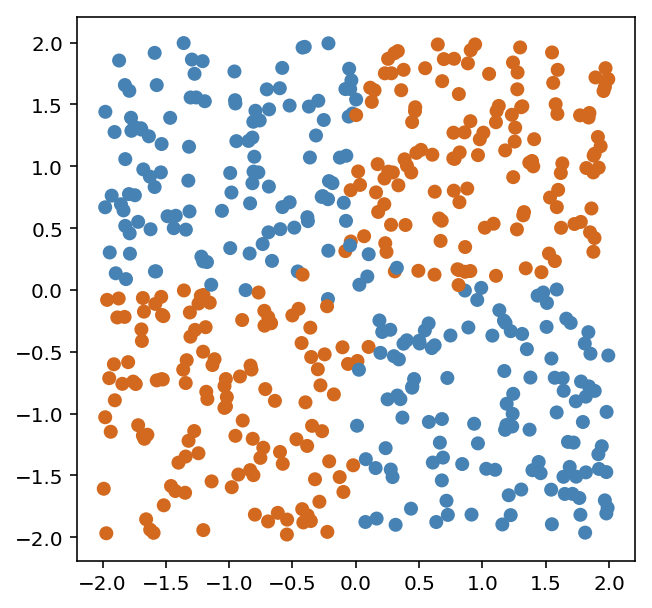

In [32]:
import pandas as pd

df = pd.read_csv("xor.csv")
features_2d = df.loc[:, ("x", "y")]
labelv = df["label"]

plt.figure(figsize=(5, 5))
plt.scatter(features_2d.iloc[:,0], features_2d.iloc[:,1], color=samples_color(labelv));

Decision trees live in the `sklearn.tree` module.

train score: 100.00%
test score: 93.60%


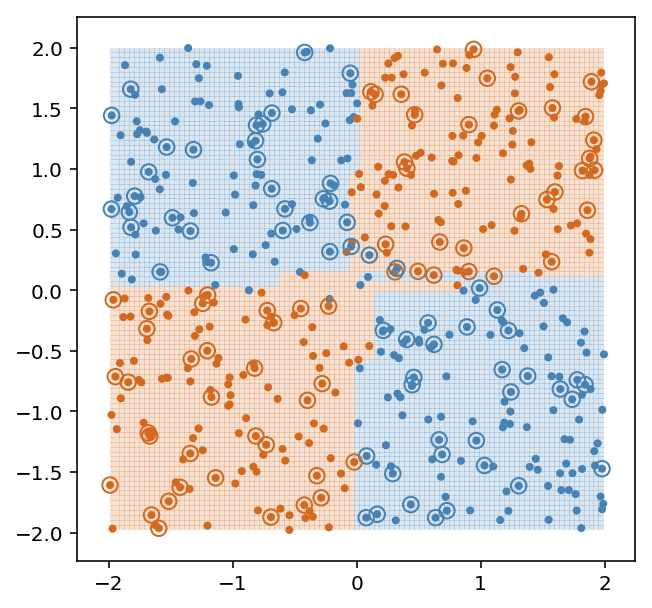

In [34]:
from sklearn.ensemble import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_2d, labelv, random_state=10)

classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)

print('train score: {:.2f}%'.format(100*classifier.score(X_train, y_train)))
print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))

plt.figure(figsize=(5, 5))
plot_decision_surface(
    features_2d, labelv, classifier,
    test_features_2d=X_test, test_labels=y_test,
)

This surface seems a bit rough on edges. How does the tree look like?

<div class="alert alert-block alert-info">
<i class="fa fa-info-circle"></i>
Next scikit-learn version (0.21) will come with a handy `sklearn.tree.plot_tree`. For now, let's use a DOT+PNG workaround.
</div>


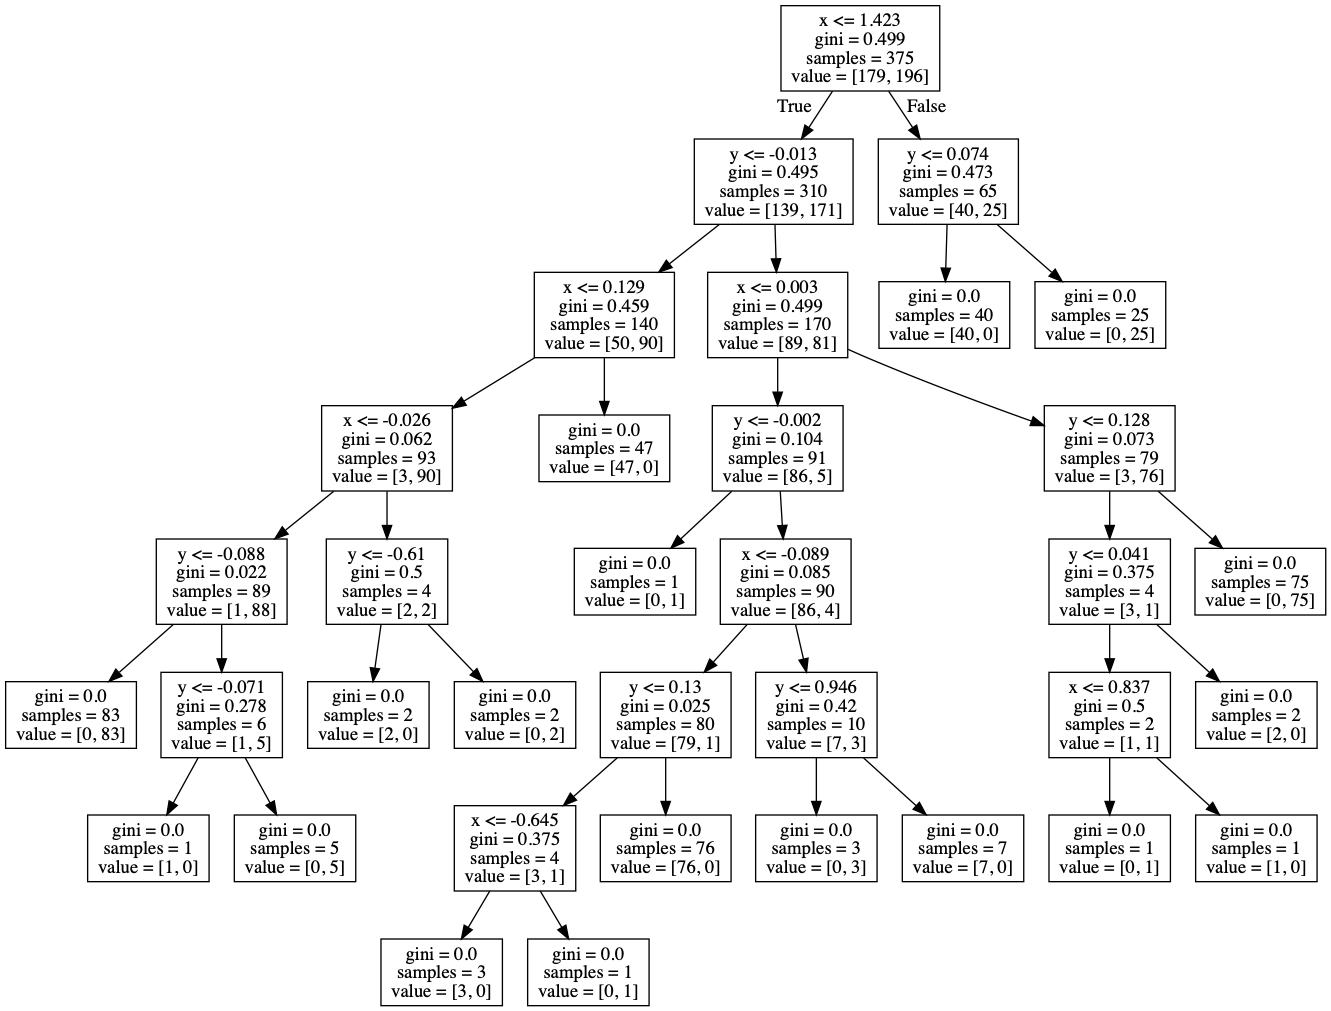

In [35]:
import pydot
from IPython.display import Image, display
from sklearn.tree import export_graphviz

def plot_decision_tree(classifier, feature_names, dot_file='temp.dot', width=None):
    export_graphviz(classifier, out_file=dot_file, feature_names=feature_names)
    graph = pydot.graph_from_dot_file(dot_file)[0]
    plt = Image(graph.create_png(), width=width)
    display(plt)

plot_decision_tree(classifier, features_2d.columns.values, width=600)

A little over the top for our data. It's so complex (overfitted) because by default a decision tree is built until all nodes are "pure" (`gini = 0.0`).

### How to avoid overfitting?

There is no regularization penalty like in logistic regression or SVM methods when bulding a decision tree. Instead we can set hyperparameters for the build such as:
* maximum tree depth (`max_depth`), or
* a minimum number of samples required at a node or a leaf node (`min_samples_split`, `min_samples_leaf`), or
* an early stopping criteria based on minumum value of or minimum decrease in impurity (`min_impurity_split`, `min_impurity_decrease`), and some more (see docs).

<div class="alert alert-block alert-info"><i class="fa fa-info-circle"></i>
    You might also hear about a <em>tree pruning</em> which is done after the tree has been built, but scikit-learn does not (currently) support such feature.
</div>

### Exercise section

1. In principle for our XOR dataset it should suffice to use each feature exactly once. Try to built a smaller tree using different values for `max_depth` or `min_samples_leaf` parameters.
2. Build a decision tree for the `"beers.csv"` dataset.

   alcohol_content  bitterness  darkness  fruitiness  is_yummy
0         3.739295    0.422503  0.989463    0.215791         0
1         4.207849    0.841668  0.928626    0.380420         0
test score: 91.23%


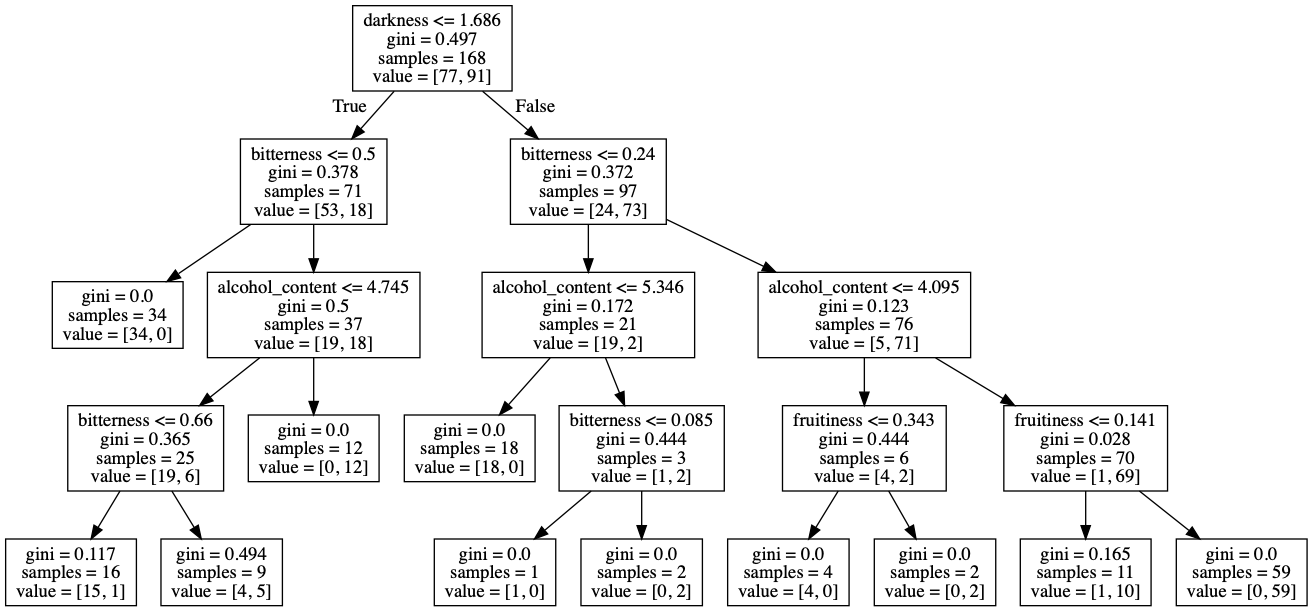

In [37]:
# SOLUTION
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

df = pd.read_csv("beers.csv")
print(df.head(2))

features_4d = df.iloc[:, :-1]
labelv = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(features_4d, labelv, random_state=0)

classifier = DecisionTreeClassifier(max_depth=4)
classifier.fit(X_train, y_train)

print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))

plot_decision_tree(classifier, features_4d.columns.values)

One **issue with decision trees is their instability** - a small changes in the training data usually results in a completely different order of splits (different tree structure).

## Ensemble Averaging: Random Forests

The idea of Random Forest method is to generate **ensemble of many "weak" decision trees** and by **averaging out their probabilistic predictions**. (The original Random Forests method used voting.)


Weak classifier here are shallow trees with feature-splits picked only out of random subsets of features (*features bagging*).

<table>
    <tr><td><img src="random_forest.png" width=800px></td></tr>
    <tr><td><center><sub>Source: <a href="https://towardsdatascience.com/random-forests-and-decision-trees-from-scratch-in-python-3e4fa5ae4249">https://towardsdatascience.com/random-forests-and-decision-trees-from-scratch-in-python-3e4fa5ae4249</a></sub></center></td></tr>
</table>


You will find Random Forest method implementation in the `sklearn.ensemble` module.

   alcohol_content  bitterness  darkness  fruitiness  is_yummy
0         3.739295    0.422503  0.989463    0.215791         0
1         4.207849    0.841668  0.928626    0.380420         0


Random Forest
test score: 84.21%

Tree #0
test score: 82.46%


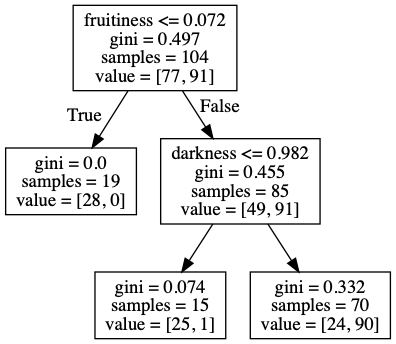

Tree #1
test score: 71.93%


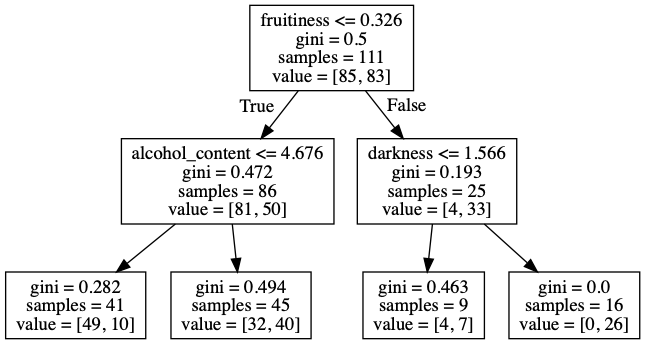

Tree #2
test score: 73.68%


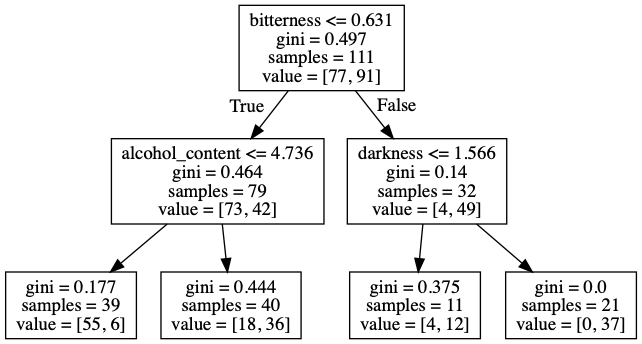

In [40]:
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

df = pd.read_csv("beers.csv")
print(df.head(2))

features_4d = df.iloc[:, :-1]
labelv = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(features_4d, labelv, random_state=10)

# For presentation purpose: 3 shallow trees, each picking only from 2 random features
classifier = RandomForestClassifier(max_depth=2, n_estimators=3, max_features=2, random_state=0)
classifier.fit(X_train, y_train)

print()
print()
print("Random Forest")
print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))
print()
for i, internal_classifier in enumerate(classifier.estimators_):
    print("Tree #{}".format(i))
    print('test score: {:.2f}%'.format(100*internal_classifier.score(X_test, y_test)))
    plot_decision_tree(internal_classifier, features_4d.columns.values, width=400)

Random forests are fast and shine with high dimensional data (many features).

<div class="alert alert-block alert-info">
<i class="fa fa-info-circle"></i>
    Random Forest can estimate <em>out-of-bag error</em> (OOB) while learning (set <code>oob_score=True</code>). It's a generalisation (predictive) error, similar to cross validation accuracy (cf. https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html )
</div>

## Why does ensemble learning work?

Ensemble learning works because probability of making an error by majority of the classifiers in the ensemble is much lower then error that each of the weak classifiers makes alone.

Furthermore, the ensemble classifier is more roboust (has lower variance) with respect to the training data.

The weak classifiers are themselve small, fast to learn, and, in case of averaging methods, they can be learnet in parallel.

In general, **usually ensemble classifier performs better than any of the weak classifiers in the ensemble**.

## Boosting: AdaBoost


Boosting is another sub-type of ensemble learning. Same as in averaging, the idea is to generate many **weak classifiers to create a single strong classifier**, but in contrast to averaging, the classifiers are learnt **iteratively**.

Each iteration focuses more on **previously misclassified samples**. To that end, **data samples are weighted**, and after each learning iteration the data weights are readjusted.

AdaBoost (“Adaptive Boosting”), is a baseline boosting algorithm that originally used decisoin trees as weak classifiers, but, in principle, **works with any classification method** (`base_estimator` parameter).

In each AdaBoost learning iteration, additionally to samples weights, the **weak classifiers are weighted**. Their weights are readjusted, such that **the more accurate a weak classifier is, the larger its weight is**.

<table>
    <tr><td><img src="AdaBoost.png" width=800px></td></tr>
    <tr><td><center><sub>Source: Marsh, B., (2016), <em>Multivariate Analysis of the Vector Boson Fusion Higgs Boson</em>.</sub></center></td></tr>
</table>

The final prediction is a weighted majority vote or weighted sum of predictions of the weighted weak classifiers.
The more accurate the classifier, the larger the weight.


You will find AdaBoost algorithm implementation in the `sklearn.ensemble` module.

In [42]:
import pandas as pd

from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split

df = pd.read_csv("beers.csv")
print(df.head(2))

features_4d = df.iloc[:, :-1]
labelv = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(features_4d, labelv, random_state=10)

# For presentation purpose: 
# * 10 single decision node trees
#   (default base_estimator is DecisionTreeClassifier(max_depth=1))
# * discrete AdaBoost 'SAMME' algorithm
#   (with default real AdaBoost 'SAMME.R' algorithm all weights are 1 at the end)
classifier = AdaBoostClassifier(n_estimators=10, algorithm='SAMME', random_state=0)
classifier.fit(X_train, y_train)

print()
print()
print("Random Forest")
print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))
print()
for i, internal_classifier in enumerate(classifier.estimators_):
    print()
    print("Tree #{}".format(i))
    # Note: 
    print("weight {:.2f}".format(classifier.estimator_weights_[i]))
    print("train error {:.2f}".format(classifier.estimator_errors_[i]))
    print('test score: {:.2f}%'.format(100*internal_classifier.score(X_test, y_test)))

   alcohol_content  bitterness  darkness  fruitiness  is_yummy
0         3.739295    0.422503  0.989463    0.215791         0
1         4.207849    0.841668  0.928626    0.380420         0


Random Forest
test score: 91.23%


Tree #0
weight 0.75
train error 0.32
test score: 66.67%

Tree #1
weight 1.21
train error 0.23
test score: 73.68%

Tree #2
weight 1.21
train error 0.23
test score: 63.16%

Tree #3
weight 1.19
train error 0.23
test score: 73.68%

Tree #4
weight 0.52
train error 0.37
test score: 66.67%

Tree #5
weight 1.07
train error 0.26
test score: 59.65%

Tree #6
weight 0.73
train error 0.33
test score: 63.16%

Tree #7
weight 0.50
train error 0.38
test score: 43.86%

Tree #8
weight 0.69
train error 0.33
test score: 82.46%

Tree #9
weight 0.47
train error 0.38
test score: 43.86%


Boosting works very well out of the box. There is no need to fine tune method hyperparameters to get good performance.

### Gradient Tree Boosting

In practice you will mostly want to use a different method called Gradient Tree Boosting (GTB). It re-formulates boosting problem as an optimization problem which is solved with efficient Stochastic Gradient Descent optimization method (more on that in the neuronal networks script).

In contrast to AdaBoost, GTB relies on using decision trees.

In particular, try out XGboost (https://xgboost.readthedocs.io/en/latest/ ; it won many Kaggle competitions: https://www.kaggle.com/dansbecker/xgboost ). It is not part of scikit-learn, but it offers a scikit-learn API (see https://www.kaggle.com/stuarthallows/using-xgboost-with-scikit-learn ).


## Coding session

Compare mean cross validation accuracy, precision and recall scores for all classifiers shown in this script using the `"beer.csv"` data. Try to squeeze better than default performance out of the classifiers by tuning their hyperparameters. Which ones perform best?


(*) Compare timing of both learning and CV scoring parts.

In [43]:
from sklearn.model_selection import cross_val_score

# cross_val_score(classifier, features_4d, labelv, scoring="recall", cv=5)

## Summary

You should be able now to understand better the classification part of the ["Choosing the right estimator" scikit-learn chart ](https://scikit-learn.org/stable/tutorial/machine_learning_map/):


<table>
    <tr><td><img src="scikit-learn_ml_map-classification.png" width=800px></td></tr>
    <tr><td><center><sub>Source: <a href="https://scikit-learn.org/stable/tutorial/machine_learning_map/">https://scikit-learn.org/stable/tutorial/machine_learning_map/</a></sub></center></td></tr>
</table>

Copyright (C) 2019 ETH Zurich, SIS ID